# Globals

In [ ]:
!pip install keras-tuner
!pip install scikit-plot

     |████████████████████████████████| 98 kB 4.7 MB/s 


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL

import pathlib
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
#import kerastuner as kt

In [ ]:
# Cargamos Dataset usado por Nacho para ML - Conexion Drive 
# Importar drive y pandas
from google.colab import drive
drive.mount('/content/drive')

project_id = 'angelic-cat-338018'
!gcloud config set project {project_id}

#Conexion Cloud
from google.colab import auth
auth.authenticate_user()


Mounted at /content/drive
Updated property [core/project].


To take a quick anonymous survey, run:
  $ gcloud survey



In [ ]:
img_height = 128
img_width = 128
batch_size = 32 # opcion 2

# Data Cleaning & Data Engineering

In [ ]:
dataset_url = "https://storage.googleapis.com/tfmbucket1/images/train/Dataset.tar"
data_dir = tf.keras.utils.get_file('Dataset', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

3268132864/3268118016 [==============================] - 29s 0us/step


El repositorio de imagenes contiene:  612646  elementos


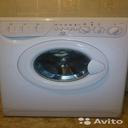

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print("El repositorio de imagenes contiene: ", image_count, " elementos")

appliances = list(data_dir.glob('Appliances/*'))
PIL.Image.open(str(appliances[0]))

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 612646 files belonging to 14 classes.
Using 490117 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 612646 files belonging to 14 classes.
Using 122529 files for validation.


# Preparamos para Modelo de venta Sold/No Sold

In [ ]:
!pip install tarfile

ERROR: Could not find a version that satisfies the requirement tarfile (from versions: none)
ERROR: No matching distribution found for tarfile


In [ ]:
dataset_url = "https://storage.googleapis.com/tfmbucket1/images/train/Dataset.tar"
data_dir = tf.keras.utils.get_file('Dataset', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

image_count = len(list(data_dir.glob('*/*.jpg')))
print("El repositorio de imagenes contiene: ", image_count, " elementos")

El repositorio de imagenes contiene:  931441  elementos


In [ ]:
img_height = 128
img_width = 128 
batch_size = 32 # opcion 2

dataset_url = "https://storage.googleapis.com/tfmbucket1/images/train/Dataset_bin.tar" # Nueva ruta
data_dir = tf.keras.utils.get_file('Dataset_bin', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

image_count = len(list(data_dir.glob('*/*.jpg')))
print("El repositorio de imagenes contiene: ", image_count, " elementos")


train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

In [ ]:
# Number of training examples and labels
num_train = tf.data.experimental.cardinality(train_ds).numpy() * batch_size
num_validation = tf.data.experimental.cardinality(val_ds).numpy() * batch_size
num_classes =  2
num_iterations = int(tf.data.experimental.cardinality(train_ds).numpy()) 

In [ ]:
def normalize_img(image, label, img_size):
    # Resize image to the desired img_size and normalize it
    # One hot encode the label
    image = tf.image.resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.
    label = label #tf.one_hot(label, depth=num_classes) No haria falta onehot no??
    return image, label
    
def preprocess_data(train, validation, batch_size, img_size):
    # Apply the normalize_img function on all train and validation data and create batches
    train_processed = train.map(lambda image, label: normalize_img(image, label, img_size))
    
    # If your data is already batched (eg, when using the image_dataset_from_directory function), remove .batch(batch_size)
    train_processed = train_processed.repeat()
    
    validation_processed = validation.map(lambda image, label: normalize_img(image, label, img_size))
    
    # If your data is already batched (eg, when using the image_dataset_from_directory function), remove .batch(batch_size)
    validation_processed = validation_processed
    
    return train_processed, validation_processed
    
# Run preprocessing
train_processed_224, validation_processed_224 = preprocess_data(train_ds, val_ds, batch_size, img_size=[224,224])
train_processed_331, validation_processed_331 = preprocess_data(train_ds, val_ds, batch_size, img_size=[331,331])

In [ ]:
# Imports
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import matplotlib.pyplot as plt
import inspect
from tqdm import tqdm

# Set batch size for training and validation

def corrermodelo_bin(model_name, model):
 # for model_name, model in attrib:
      # Special handling for "NASNetLarge" since it requires input images with size (331,331)
      if 'NASNetLarge' in model_name:
          input_shape=(331,331,3)
          train_processed = train_processed_331
          validation_processed = validation_processed_331
      else:
          input_shape=(224,224,3)
          train_processed = train_processed_224
          validation_processed = validation_processed_224
          
      # load the pre-trained model with global average pooling as the last layer and freeze the model weights
      pre_trained_model = model(include_top=False, pooling='avg', input_shape=input_shape)
      pre_trained_model.trainable = False
      
      # custom modifications on top of pre-trained model and fit
      clf_model = tf.keras.models.Sequential()
      clf_model.add(pre_trained_model)
      clf_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
      clf_model.compile(loss='binary_crossentropy', metrics=['accuracy'])
      history = clf_model.fit(train_processed, epochs = 1, validation_data=validation_processed, steps_per_epoch=num_iterations)
      
      # Calculate all relevant metrics
      model_benchmarks['model_name'].append(model_name)
      model_benchmarks['num_model_params'].append(pre_trained_model.count_params())
      model_benchmarks['validation_accuracy'].append(history.history['val_accuracy'][-1])

      clf_model.save('/content/' + model_name, save_format = 'h5')
      !gsutil cp -r /content/{model_name} gs://tfmbucket1/models


In [ ]:
model_benchmarks = {'model_name': [], 'num_model_params': [], 'validation_accuracy': []}
model_dictionary = {m[0]:m[1] for m in inspect.getmembers(tf.keras.applications, inspect.isfunction)}

In [ ]:
keys_list = list(model_dictionary)
values = list(model_dictionary.values())
model_dictionary

# Modelo Ganador Redes Densas

In [ ]:
#DenseNet201
corrermodelo(keys_list[2], values[2])
print("Hecho")
#loss: 0.7961 - accuracy: 0.6947 - val_loss: 0.0806 - val_accuracy: 0.6896

Cargar modelo ya entrenado de google

In [ ]:
from tensorflow.keras.models import Sequential, load_model
# Importing saved model
output_dir =  '/content/'
model_trained = load_model(output_dir + 'models_DenseNet201')

Export el modelo en archivos para subir al Frontend

In [ ]:
#Exportacion del modelo a h5
model_trained.save('modelo_exportado.h5')

In [ ]:
#Instalar tensorflowjs para convertir el h5 a un modelo que pueda cargar tensorflowjs en un explorador
!pip install tensorflowjs

     |████████████████████████████████| 77 kB 2.8 MB/s 


In [ ]:
#Convertir el archivo h5 a formato de tensorflowjs
!mkdir tfjs_target_dir
!tensorflowjs_converter --input_format keras modelo_exportado.h5 tfjs_target_dir

In [ ]:
#Veamos si si creo la carpeta
!ls

adc.json	     models_DenseNet121  sample_data
modelo_exportado.h5  models_DenseNet201  tfjs_target_dir


In [ ]:
#Veamos el contenido de la carpeta
!ls tfjs_target_dir

group1-shard10of18.bin	group1-shard17of18.bin	group1-shard6of18.bin
group1-shard11of18.bin	group1-shard18of18.bin	group1-shard7of18.bin
group1-shard12of18.bin	group1-shard1of18.bin	group1-shard8of18.bin
group1-shard13of18.bin	group1-shard2of18.bin	group1-shard9of18.bin
group1-shard14of18.bin	group1-shard3of18.bin	model.json
group1-shard15of18.bin	group1-shard4of18.bin
group1-shard16of18.bin	group1-shard5of18.bin


Crear ZIP y bajar archivos para compartir

In [ ]:
#Crear ZIP
!zip -r /content/file.zip /content/tfjs_target_dir

  adding: content/tfjs_target_dir/ (stored 0%)
  adding: content/tfjs_target_dir/group1-shard6of18.bin (deflated 6%)
  adding: content/tfjs_target_dir/group1-shard10of18.bin (deflated 7%)
  adding: content/tfjs_target_dir/group1-shard5of18.bin (deflated 6%)
  adding: content/tfjs_target_dir/model.json (deflated 97%)
  adding: content/tfjs_target_dir/group1-shard11of18.bin (deflated 7%)
  adding: content/tfjs_target_dir/group1-shard4of18.bin (deflated 6%)
  adding: content/tfjs_target_dir/group1-shard16of18.bin (deflated 6%)
  adding: content/tfjs_target_dir/group1-shard17of18.bin (deflated 6%)
  adding: content/tfjs_target_dir/group1-shard13of18.bin (deflated 6%)
  adding: content/tfjs_target_dir/group1-shard8of18.bin (deflated 6%)
  adding: content/tfjs_target_dir/group1-shard7of18.bin (deflated 6%)
  adding: content/tfjs_target_dir/group1-shard12of18.bin (deflated 6%)
  adding: content/tfjs_target_dir/group1-shard18of18.bin (deflated 6%)
  adding: content/tfjs_target_dir/group1-shard

In [ ]:
#Descargar ZIP
from google.colab import files
files.download("/content/file.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Graficas del modelo

In [ ]:
# Convert Results to DataFrame for easy viewing
benchmark_df = pd.DataFrame(model_benchmarks)

# sort in ascending order of num_model_params column
benchmark_df.sort_values('num_model_params', inplace=True)

# write results to csv file
benchmark_df.to_csv('benchmark_df.csv', index=False)
benchmark_df

In [ ]:
# Loop over each row and plot the num_model_params vs validation_accuracy
markers=[".",",","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d","|","_",4,5,6,7,8,9,10,11]
plt.figure(figsize=(7,5))

for row in benchmark_df.itertuples():
    plt.scatter(row.num_model_params, row.validation_accuracy, label=row.model_name, marker=markers[row.Index], s=150, linewidths=2)
    
plt.xscale('log')
plt.xlabel('Number of Parameters in Model')
plt.ylabel('Validation Accuracy after 3 Epochs')
plt.title('Accuracy vs Model Size')

# Move legend out of the plot
plt.legend(bbox_to_anchor=(1, 1), loc='upper left');